In [2]:
# compare bin0 and closest strain
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from striprtf.striprtf import rtf_to_text
import json
import itertools
import networkx as nx
import imp
from adjustText import adjust_text

In [6]:
# obtain KO from protein fasta file using kofamKOALA
# https://www.genome.jp/tools/kofamkoala/
# NCBI: https://www.ncbi.nlm.nih.gov/assembly/GCA_002256705.1
# GTDB: https://gtdb.ecogenomic.org/genome?gid=GCA_002256705.1
# download the results txt and saved as "NMS2-1.txt"
def prep_df(inp1,inp2):
    """
    merge the dataframe to one
    inp1 contains bin0 and KS41
    inp2 contains NMS2-1
    """
    df = pd.read_csv(inp1,sep='\t')
    df = pd.concat([df.iloc[:,0].astype("string"),df.iloc[:,1:]],axis=1)
    ko2 = pd.read_csv(inp2,sep='\t',\
        comment="#",header=None)[0].str.split(expand=True)# skiprows=2; 
    ko = ko2[2] # get the KO numbers of NMS2-1 ; there are duplicates in this
    # row.values.astype(str)
    kodef = ko2.iloc[:,6:].apply(lambda row:" ".join(row.values[row.values != np.array(None)]),axis=1) # get the ko definition
    strain = pd.Series(np.ones(ko.shape[0]),dtype=int) # the series for boolean NSM2-1
    ko2 = pd.concat([ko.astype("string"),strain,kodef],axis=1)
    ko2.columns = ["#ko","NSM2-1","ko_definition"]
    tempdf = pd.merge(df,ko2,how='outer',on='#ko')#,left_on=['#ko','ko_definition'],right_on=['#ko','ko_definition'])
    kodef = tempdf['ko_definition_x'].combine_first(tempdf['ko_definition_y'])
    kodef.name = "ko_definition"
    tempdf = tempdf.drop(["ko_definition_x","ko_definition_y"],axis=1).fillna(0)
    tempko = tempdf['#ko']
    tempv = tempdf.iloc[:,1:].astype(int)
    df2 = pd.concat([tempko,tempv,kodef],axis=1)
    df2.drop_duplicates(inplace=True)
    df2.reset_index(inplace=True,drop=True)
    return df2

inp1 = "ko_compare_closest.json.tsv"
inp2 = "NMS2-1.txt"
df = prep_df(inp1,inp2)

In [7]:
def comp_strain(df,n1,n2):
    """
    compare strain n1 and strain n2
    """
    df0 = df[n1]
    df1 = df[n2]
    # count KO for n1 and n2
    KO_0 = df0.sum()
    KO_1 = df1.sum()
    print("%s and %s have #KO of %i and %i, respectively"%(n1, n2, KO_0, KO_1))
    # find the shared ko
    sdf = df[(df0 & df1)==1] #shared df
    print("{} KOs are shared between two genome".format(sdf.shape[0]))
    return df0 ,df1, sdf
n1, n2 = 'bin_0', 'NSM2-1'
df0,df1, sdf = comp_strain(df,n1,n2)

bin_0 and NSM2-1 have #KO of 1685 and 996, respectively
804 KOs are shared between two genome


In [8]:
# peptidases BRITE : https://www.genome.jp/kegg-bin/get_htext?ko01002
# prepare the peptidase file 
with open("peptidase.json","r") as f:
    content = json.load(f)
ko = []
for i in content['children']:
    for j in i['children']:
        for l in j['children']:
            koi = l['name'].split(" ")[0]
            ko.append(koi)
f = open('kos/Peptidase.kos','w')
for i in ko:
    print(i,file=f)
f.close()
# pept = pd.read_csv('peptidase.ko',header=None)


In [42]:
import math
def viz_stat_network(df,n1,n2,general,types="shared",kwlength=3,fs=10):
    """
    # fs : node label font size
    # count frequency of word in the words
    # draw the networks
    """
    df0 = df[n1]
    df1 = df[n2]
    sdf = df[(df0 & df1)==1] #shared df
    udf = df[(np.logical_and(df1 ==1,df0==0)) | np.logical_and(df0 ==1,df1==0) ] 
    udf1 = udf[np.logical_and(udf[n1]==1,udf[n2]==0)] # unique df 1
    udf2 = udf[np.logical_and(udf[n2]==1,udf[n1]==0)] # unique df 2
    udf1_w = udf1['ko_definition'].tolist() #words

    def get_wlist(slist):
        # get word list
        wlist = [] # the word list
        for i in slist: #sentence list: a list of strings of sentence
            if isinstance(i,str):
                words = re.split(";| |/|,|\[|\]",i)
                for wordi in words:
                    if wordi != '':
                        wlist.append(wordi)
        return wlist

    def count_wlist(wlist):
        # count the word
        df = pd.Series(wlist)
        counts = df.value_counts()
        return counts

    def drop_general(count1,general):
        # drop general words
        idx = count1.index
        count1.drop(list(idx[np.argwhere(np.array([len(x) for x in idx.tolist()])<3)].flatten()),inplace=True)
        count1.drop(general,inplace=True,errors="ignore")#EC2.7.13.3 - histidine kinase
        return count1
    
    if types=="shared": # shared genome by 1 and 2
        data = sdf
    elif types=="n1": # uniq1 
        data = udf1
    elif types=="n2": # uniq2
        data = udf2
    elif types=="o1": # only genome 1
        data = df[df[n1]==1]
    elif types=='o2':
        data = df[df[n2]==1]
    
    udf1_wlist = get_wlist(data['ko_definition'].tolist())
    count1or = count_wlist(udf1_wlist) 

    count1 = count1or[count1or>=5] # drop word freq less than 5
    count1 = drop_general(count1,general)
    
    # save wordcount statistics
    fig, ax = plt.subplots(1,1,figsize=(20,3))
    ax = count1.plot.bar(ax=ax,color='g',ec='k',alpha=.3)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right',fontsize='large')
    ax.set_ylabel("Metabolic Keyword Counts",fontsize='x-large')
    ax.set_title("Statistics",fontsize='x-large')
    plt.close()
    fig.savefig("statistics.%s.wordcount.png"%types,bbox_inches='tight',dpi=600)
    
    # visualize the word list as networks
    def viz_network(data,general,kwlength):
        
        def get_network(slist,general,types=1):
            nlist = [] # the network list
            for i in slist: #sentence list: a list of strings of sentence
                if isinstance(i,str):
                    words = re.split(";| |/|,|\[|\]",i)
                    if types==1: # at least 3 words in the metabolic pathways
                        

                        words = [temp for temp in words if not (temp=='' or \
                                                                (not bool(re.search('[a-zA-Z]', temp))) or \
                                                                'EC:' in temp or temp in general)]
                        words = list(set(words))
                        words = [temp for temp in words if len(temp)>kwlength]
                    elif types==2:
                        words = [temp for temp in words if not (temp=='' or 'EC:' in temp )]
                    if len(words) >= 2:
                        pairi = list(itertools.combinations(words,2))
                        for i in pairi:
                            nlist.append(i)
            return nlist

        # network
        udf1_nlist = get_network(data['ko_definition'].tolist(),general)
        count0 = count_wlist(udf1_nlist)
        count2 = count0[count0>=3] # filtered
        # need to add phosphate back to the network
        count1 = count2.copy() # nitrogen and phosph
        for pair in count0.index:
            if 'polyphospha' in pair[0] or 'polyphospha' in pair[1] or\
            'nitr' in pair[0] or 'nitr' in pair[1] or \
            "glycogen" in pair[1] or "glycogen" in pair[0] :
                count1 = pd.concat([count1,pd.Series(count0[pair])])
                idx = count1.index.values
                idx[-1] = pair
                count1.index = idx
        count0 = count1
        
        G = nx.empty_graph()
        nodes = set() # add nodes here
        # add node
        for pair in count0.index:
            freq = count0[pair]
            G.add_edge(pair[0],pair[1],weight=freq)
            nodes.add(pair[0])
            nodes.add(pair[1])
        nodes = sorted(nodes)
        
        # edit node size and label position
        nodesize = np.zeros(len(nodes))
        labels = pd.DataFrame(np.zeros((len(nodes),2)),columns=['name','freq']) # node name, freq
        for i,node in enumerate(nodes):
            G.add_node(node)
            freq = count1or[node]
            nodesize[i] = freq*1.5
            labels.iloc[i,0] = node
            labels.iloc[i,1] = freq

        # customize node label position
        pos1 = nx.nx_agraph.pygraphviz_layout(G,prog='neato') ###
        # gvcolor, unflatten, tred, dot, gc, patchwork, ccomps, twopi, circo, fdp, nop, acyclic, neato, osage, sfdp, gvpr, sccmap.
        
        # get range of x-y axis, and range of node size
        xmax = max(pos1.values(),key=lambda x:x[0])[0]
        ymax = max(pos1.values(),key=lambda x:x[1])[1]
        xmin = min(pos1.values(),key=lambda x:x[0])[0]
        ymin = min(pos1.values(),key=lambda x:x[1])[1]
        
        nsmin,nsmax = min(nodesize), max(nodesize)
        
        nodesize = [(i-nsmin)/(nsmax-nsmin)*5 for i in nodesize]
        wordmax = len(max(pos1.keys(),key=lambda x: len(x)))
        
        pos2 = {}
        posn = {}
        
        for (k,v),ns in zip(pos1.items(),nodesize):
            pos2[k] = ((v[0]-xmin)/(xmax-xmin)-min(0.08,max(ns/100,0.03))-len(k)/wordmax/80,\
                                           (v[1]-ymin)/(ymax-ymin)-max(ns/100,0.03))
                    
            posn[k] = ((v[1]-ymin)/(ymax-ymin),(v[0]-xmin)/(xmax-xmin))# change x and y ((v[0]-xmin)/(xmax-xmin),(v[1]-ymin)/(ymax-ymin)  )

        fig, ax = plt.subplots(1,1,figsize=(10,15))
        nx.draw_networkx_nodes(G,pos=posn,linewidths=1.2,edgecolors='k',\
                               node_color='#95DABB',alpha=1,node_size=[i*20 for i in nodesize],ax=ax)
        nx.draw_networkx_edges(G,pos=posn,edge_color='r',\
                               width=count0.values/15,ax=ax)
        nodeslabel = []
        for (k,v),ns in zip(pos2.items(),nodesize):
#             if ns >= 0.1:
            if (types=="o1" and ("phospha" in k or "nitr" in k or "metha" in k or "transport" in k or "DNA" in k or "RNA" in k \
            or "furmarate" in k or "sulf" in k or "polysacc" in k \
            or "GTP" in k or "methy" in k or "monooxyg" in k or "Fe-S" in k or "ntr" in k or "nif" in k \
            or "nrf" in k or "ppk" in k or "ppx" in k or "nar" in k or "ppgK" in k or "glycogen" in k  or "23S" in k or "16S" in k or "nir" in k\
            or "nor" in k or "amc" in k or "glucos" in k)) or types == "n1" or types == "n2" :
                v = (v[1],v[0])
                nodeslabel.append(plt.text(v[1],v[0],k,fontsize=fs))
        adjust_text(nodeslabel,only_move={'points':'y',"texts":"y"})
        ax.set_title("Metabolic Keywords Network, %s"%types,fontsize='large')
        fig.savefig('network_%s.png'%types,dpi=600,bbox_inches='tight')
        # colorhex: https://dataveld.com/2019/12/31/data-color-reference-for-power-bi-themes-as-of-december-2019/
        return pos1, udf1_nlist
    pos1,udf1_nlist = viz_network(data,general,kwlength)

    return udf1, udf2, pos1, udf1_nlist


<ipython-input-42-6f9d7f1a8291>:36: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  count1.drop(list(idx[np.argwhere(np.array([len(x) for x in idx.tolist()])<3)].flatten()),inplace=True)
<ipython-input-42-6f9d7f1a8291>:36: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  count1.drop(list(idx[np.argwhere(np.array([len(x) for x in idx.tolist()])<3)].flatten()),inplace=True)


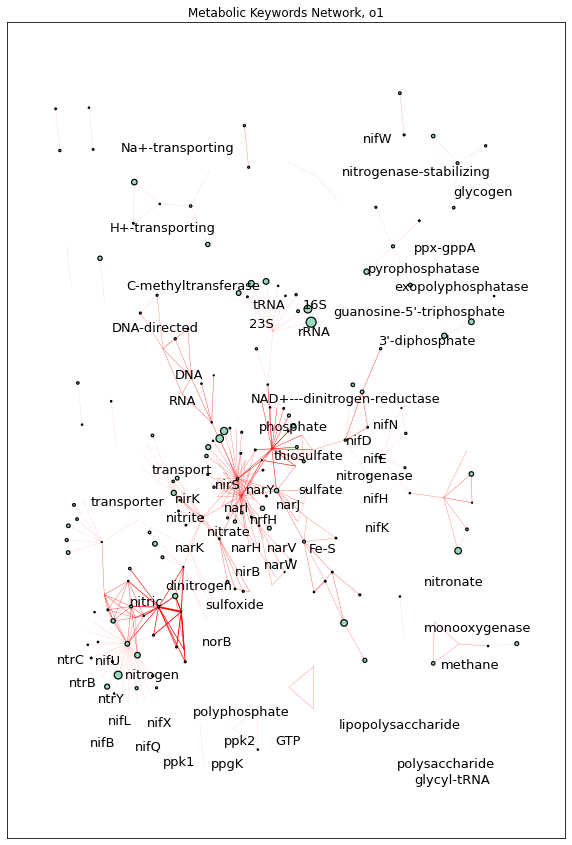

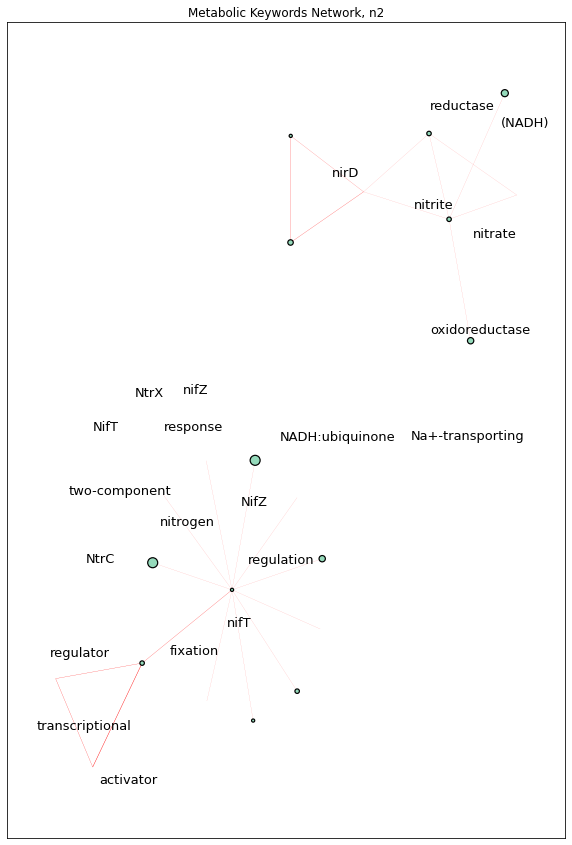

In [43]:
"""
shared : shared genome between 1 and 2, 
n1 : unique in genome 1
o1: genome 1 only
"""
general = ["protein","subunit","III","EC:2.7.13.3",'and','beta',\
                'small','alpha','type','large','system','family','cell',\
                'factor','putative','chain','component',"uncharacterized","EC:2.7.7.7",\
              "EC:3.4.24.-","ABC",'for','general','pathway','molecular','cluster'] # genral words to be deleted
for genome in ["o1","n2"]:#["shared","n1","n2","o1","o2"]: #["n2","o1"]:#
    udf1, udf2, temp, udf1_nlist = viz_stat_network(df,n1,n2,general,genome,kwlength=2,fs=13) # n1, n2 = 'bin_0', 'NSM2-1'

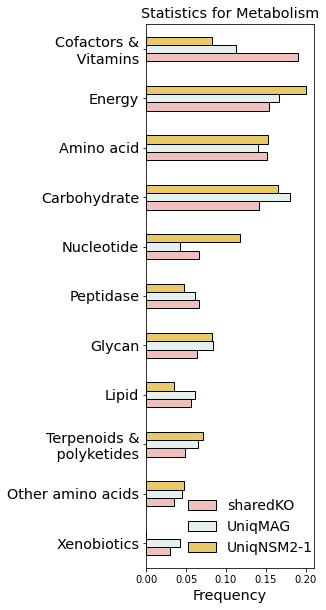

In [31]:
class metabolic_stats():
    
    def __init__(self,data,n1,n2):
        # get the ko values for all metabolism pathways
        self.data = data
        self.n1 = n1
        self.n2 = n2
        dfmt = pd.DataFrame() # dataframe of metabolism
        for mt in os.scandir("kos/"): # metabolisms
            if ".DS" not in mt.name:
                name = mt.name.replace(".kos","") # metabolism pathway name
                tempdf = pd.read_csv(mt.path,sep='\t',header=None).iloc[:,0].str.replace("ko:","",regex=True)
                tempdf.name = name
                dfmt = pd.concat([dfmt,tempdf],axis=1)
        self.dfmt = dfmt

    def get_mtvalue(self,se,idx):
        # given a Series of kos, return counts at each metabolism pathways
        # dfmt is the dataframe metabolism reference
        dfmt = self.dfmt
        counts = pd.DataFrame(np.zeros((1,dfmt.shape[1])),columns=dfmt.columns,index=[idx])
        comp = set(se.to_list()) # compared kos
        for mt in dfmt.columns:
            ref = set(dfmt[mt].to_list()) # reference kos

            kos = ref.intersection(comp) # overlapped kos
            number = len(kos) # number of overlapped kos
            counts[mt] = number
        return counts
    
    def metabolism_count(self,df,sortv,c=None):#
        # dfl : list of series with name #ko
        # namel : list of name
        counts = pd.DataFrame()
        for i in range(df.shape[1]):
            idx = df.columns[i]
            tempdf = df[idx]
            count = self.get_mtvalue(tempdf,idx)
            count = count/count.sum().sum() # normalize
            counts = pd.concat([counts,count])
        counts = counts.sort_values(by=sortv,axis=1)
        colname = counts.columns.values
        customize_name = {'Xenobiotics biodegradation and metabolism':"Xenobiotics",
                         'Metabolism of other amino acids':"Other amino acids",
                         'Metabolism of terpenoids and polyketides':"Terpenoids &\n polyketides",
                          'Lipid metabolism':"Lipid",
                         'Glycan biosynthesis and metabolism':"Glycan",
                          'Peptidase':'Peptidase',
                          'Nucleotide metabolism':"Nucleotide",
                         'Carbohydrate metabolism':"Carbohydrate",
                          'Amino acid metabolism':"Amino acid",
                          'Energy metabolism':"Energy",
                         'Metabolism of cofactors and vitamins':"Cofactors &\n Vitamins"}
        colname = [customize_name[i] for i in colname]
        counts.columns = colname
        
        fig, ax = plt.subplots(1,1,figsize=(3,10))
        # https://www.color-hex.com/color-palette/1017895
        if c != None:
            ax = counts.T.plot.barh(ax=ax,width=.5,ec='k',color=c,)
        else: 
            ax = counts.T.plot.barh(ax=ax,width=.5,ec='k')
        ax.set_yticklabels(ax.get_yticklabels(),ha='right',fontsize='x-large')
        ax.set_xlabel("Frequency",fontsize='x-large')
        ax.legend(loc='lower right',fontsize=14,frameon=False,bbox_to_anchor=(0.07,0,1,1))
        ax.set_title("Statistics for Metabolism",fontsize='x-large')
        plt.show()
        return counts, fig
    
    

def metabolism_stats(df,n1,n2):
    # Statistics 1  
    obj = metabolic_stats(df,n1,n2)
    df = pd.DataFrame()
    data = obj.data
    n1 = obj.n1
    n2 = obj.n2
    df0,df1 = data[n1], data[n2] 
    sdf = data[(df0 & df1)==1] #shared df
    udf = data[(df0 & df1)==0] 
    udf1 = udf[udf[n1]==1] # unique df 1
    udf2 = udf[udf[n2]==1] # unique df 2
    for tempse in [sdf['#ko'],udf1['#ko'],udf2['#ko']]:
        df = pd.concat([df,tempse],axis=1)
    
    #df.columns = ["sharedKO",'Uniq%s'%n1,'Uniq%s'%n2]
    df.columns = ["sharedKO",'UniqMAG','Uniq%s'%n2]

    counts, fig = obj.metabolism_count(df,['sharedKO'],["#f0c1bc","#e4f0eb","#e8c966"])
    fig.savefig("statistics.metabolism.png",bbox_inches='tight',dpi=600)
metabolism_stats(df,n1,n2)

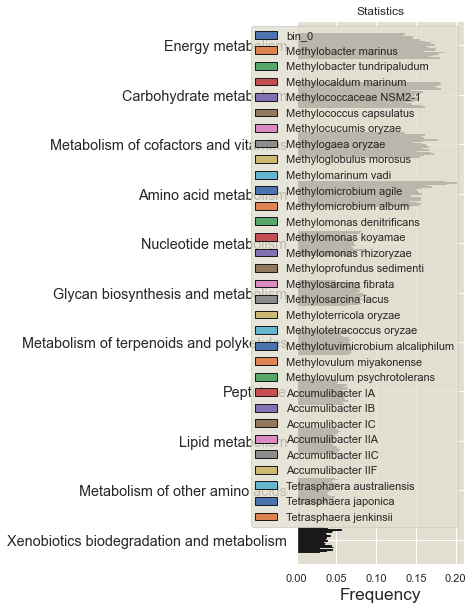

In [318]:
# Statistics 2
# prepare NSM2-1

# load all kos
data = pd.DataFrame()
for genus in os.scandir("../comparative_genomics/koall"):
    if ".DS" not in genus.name: # is directory
        for strain in os.scandir(genus.path):
            if ".DS" not in strain.name:
                files = os.listdir(strain.path)
                if ".DS_Store" in files:
                    files.remove(".DS_Store")
                tempko = pd.read_csv(os.path.join(strain.path,files[0]),sep='\t',header=None)[1]
                if genus.name != strain.name:
                    tempko.name = genus.name + " " + strain.name
                else: 
                    tempko.name = genus.name # bin_0
                data = pd.concat([data,tempko],axis=1)
NSM2 = pd.read_csv("NMS2-1.txt",comment="#",sep='\t',header=None)[0].str.split(expand=True)[2]
NSM2.name = "Methylococcaceae NSM2-1"
data = pd.concat([data,NSM2],axis=1)
temp = data.columns.tolist()
temp.sort()
temporder = [temp[-1],*temp[6:-5],*temp[:6],*temp[-5:-2]]
data = data.reindex(columns=temporder)
counts2, fig2 = metabolic_stats(df,n1,n2).metabolism_count(data,"bin_0")

<ipython-input-343-781a8b4ea908>:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(prm, dtype=np.bool)


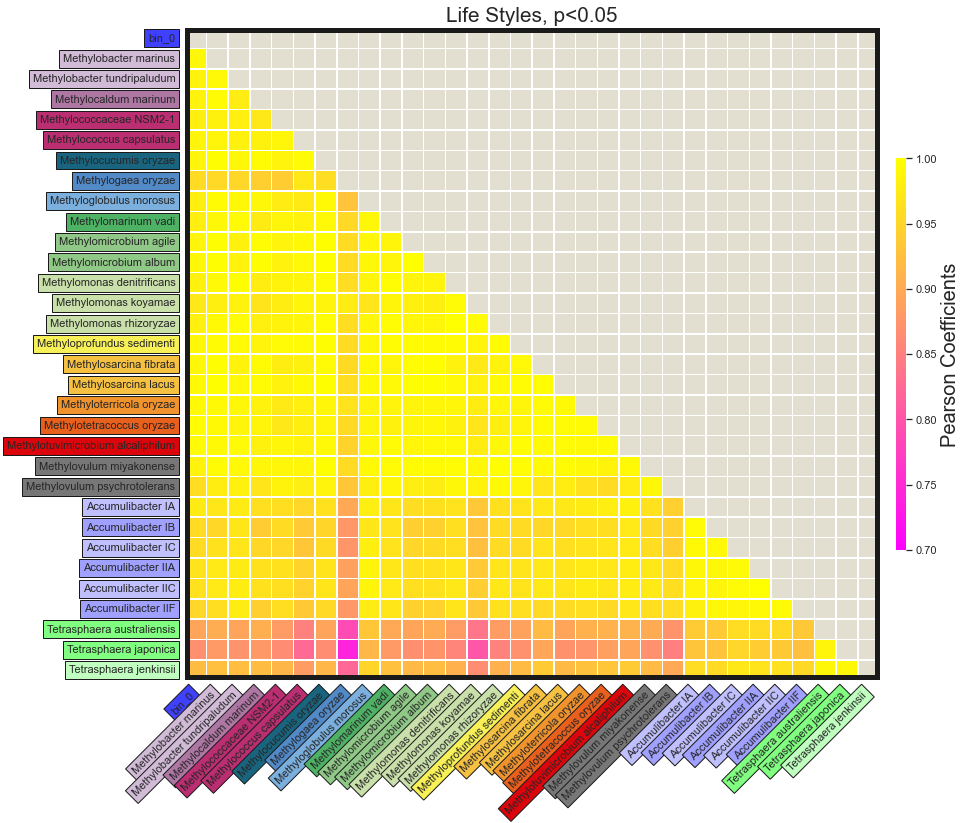

In [343]:
from itertools import combinations
from scipy.stats import pearsonr
import seaborn as sns
# Pearson matrix between strains
n,d = counts2.shape
comb = sorted(set(combinations(np.arange(n,dtype=int),2))) # combinations
prm = np.ones((n,n))#Pearson coefficient matrix
prv = np.zeros((n,n))#Pearson p-value matrix
for combi in comb:
    i, j = combi
    pr,pv = pearsonr(counts2.iloc[int(i),:],counts2.iloc[int(j),:])
    prm[i,j] = pr
    prm[j,i] = pr
    prv[i,j] = pv
    prv[j,i] = pv
# Generate a mask for the upper triangle
mask = np.zeros_like(prm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#
prm = pd.DataFrame(prm,columns=counts2.index,index=counts2.index)
fig2, ax2 = plt.subplots(1,1,figsize=(15,12))
sns.set(rc={"axes.facecolor":"#E2DED0"})
# cbar_ax = fig2.add_axes([.91, .3, .03, .4])
ax2 = sns.heatmap(prm, cmap="spring",mask=mask,#Set3
                  vmin=0.7, vmax=1,\
                  linewidths=.5, #cbar_ax = cbar_ax,
                  cbar_kws={'shrink':0.6,'label':'Pearson Coefficients',\
                           'pad':0.02,'aspect':40},ax=ax2,\
                  edgecolor='k')
ax2.figure.axes[-1].yaxis.label.set_size(20)
ax2.set_title("Life Styles, p<0.05",fontsize='xx-large')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45,ha='right')

# set color range 
# load genus color
f = open("../comparative_genomics/color.json",'r')
dict_gc = json.load(f)
f.close()
for ticklabels in [ax2.get_xticklabels(),ax2.get_yticklabels()]:
    for ticklabel in ticklabels:
        ticktext = ticklabel.get_text()
        gs = str(ticktext)
        ticklabel.set_bbox(dict(edgecolor='k',facecolor=dict_gc[gs]))

ax2.axhline(y=0, color='k',linewidth=10)
ax2.axhline(y=prm.shape[1], color='k',linewidth=10)
ax2.axvline(x=0, color='k',linewidth=10)
ax2.axvline(x=prm.shape[0], color='k',linewidth=10)
fig2.savefig("../comparative_genomics/corr.png",bbox_inches='tight',dpi=600)
# https://stackoverflow.com/questions/36560829/how-to-create-a-seaborn-heatmap-with-frames-around-the-tiles

In [39]:
# get the unique and shared ko file to kegg
def get_kostr(udf):
    kostr =  udf['#ko'].iloc[0] # ko string
    for ko in udf['#ko'].iloc[1:]:
        kostr += ', {}'.format(ko)
    return kostr

kostr1 = get_kostr(udf1) # ko unique bin0
kostr2 = get_kostr(udf2) # ko unique KS41
sstr = get_kostr(sdf) # ko shared of bin0 and KS41
allstr = get_kostr(df[df['bin_0']==1]) # ko all bin0
def save(name,kostr):
    f = open(name,'w')
    print(kostr,file=f)
    f.close()

save("ko_unique1.txt",kostr1)
save("ko_unique2.txt",kostr2)
save("ko_shared.txt",sstr)
save("ko_bin0.txt",allstr)


In [201]:
def get_name(rtfp):
    # rtfp: rtf file path
    
    with open(rtfp) as infile:
        content = infile.read()
        text = rtf_to_text(content)
    textl = text.split('\n')
    pid1 = [] # parent pathway id 1
    pid2 = [] # daughter ko id 2
    for i in range(len(textl)):
        if textl[i].startswith("\t\tko"): # this is first KO pathway
            pid1.append(i)
        elif textl[i].startswith("\t\t\xa0\xa0ko"): # this is second KO number for pathway
            pid2.append(i)

    pid1 = np.asarray(pid1)
    pid2 = np.asarray(pid2)
    pid3 = []
    for i in range(len(pid1)):
        if i != len(pid1)-1:
            pid3.append(pid2[np.logical_and(pid2>pid1[i],pid2<pid1[i+1])])
        else:
            pid3.append(pid2[pid2>pid1[i]])
    path1 = [textl[i] for i in pid1]
    spath1 = [np.asarray(textl)[i] for i in pid3]# son ko of path1
    path1name = [ re.search(" (.*?)\xa0",i)[0][1:-1] for i in path1] # the pathway name
    spath1ko = [] # the son ko number
    spath1name = [] # the son EC name
    for i in spath1:
        temp1ko,temp1name = [], []
        for j in i:
            temp1ko.append(re.search("\xa0ko(.*?)\(",j)[0][4:-1])
            temp1name.append(re.search("\) (.*?).*",j)[0][2:])

        spath1name.append(temp1name)
        spath1ko.append(temp1ko)
    
    dict1 = {}
    for i in range(len(path1name)):
        dict1[path1name[i]] = (spath1ko[i],spath1name[i]) # keys: metabolic pathway name, values: son ko, son EC
    return dict1

In [202]:
dict1 = get_name("kegg_uniq1.rtf")
dict2 = get_name("kegg_uniq2.rtf")

In [214]:
uniq1 = list(set(dict1.keys()).difference(set(dict2.keys()))) # A.difference(B) aka A-B, pathway
uniq2 = list(set(dict2.keys()).difference(set(dict1.keys())))

In [218]:
uniq1_EC = dict1[uniq1[0]] # K00123 numbers, and symbol/EC

(['K00172', 'K15778', 'K20866'],
 ['porC; pyruvate ferredoxin oxidoreductase gamma subunit [EC:1.2.7.1]',
  'pmm-pgm; phosphomannomutase / phosphoglucomutase [EC:5.4.2.8 5.4.2.2]',
  'yihX; glucose-1-phosphatase [EC:3.1.3.10]'])